## Pipelines that needs to be performed:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
#!pip install plotly

In [63]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
from tqdm import tqdm

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints.json', 'r') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.shape

(78313, 22)

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
cols = [re.sub('^_','',col) for col in df.columns]
cols = [re.sub('source.','',col) for col in cols]
df.columns = cols

In [8]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [9]:
df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [10]:
#Assign nan in place of blanks in the complaints column
df.complaint_what_happened = df.complaint_what_happened.apply(lambda x: np.nan if x == '' else x)

In [11]:
df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened      57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [12]:
#Remove all rows where complaints column is nan
df = df[~(df.complaint_what_happened.isnull())]

In [13]:
df.complaint_what_happened

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

## Prepare the text for topic modeling


In [14]:
#Remove words containing numbers
def clean_word(x):
    x_list = x.split(' ')
    for i,word in enumerate(x_list):
        if re.match('\w*\d\w*', word):
            x_list[i] = ''
    return(' '.join(x_list))

In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text():
    df.complaint_what_happened = df.complaint_what_happened.apply(lambda x: x.lower())
    df.complaint_what_happened = df.complaint_what_happened.apply(lambda x: re.sub('/[*/]','',x))
    df.complaint_what_happened = df.complaint_what_happened.apply(lambda x: x.replace('!',''))
    df.complaint_what_happened = df.complaint_what_happened.apply(clean_word)

In [16]:
clean_text()

In [17]:
df.complaint_what_happened

1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in xx/xx/2018 and...
10       chase card was reported on xx/xx/2019. however...
11       on xx/xx/2018, while trying to book a xxxx  xx...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday, xx/xx/xxxx i called chas, my xxx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for  yrs. i've had ...
78312    roughly  years ago i closed out my accounts wi...
Name: complaint_what_happened, Length: 21072, dtype: object

In [18]:
#Write your function to Lemmatize the texts
def lemma_word(x):
    sent = []
    doc = nlp(x)
    for tok in doc:
        sent.append(tok.lemma_)
    return " ".join(sent)

In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()
df_clean['complaint_what_happened'] = df.complaint_what_happened
#df_clean['lemmatized_complaints'] = df.complaint_what_happened.apply(lemma_word)

In [20]:
tqdm.pandas()
df_clean['lemmatized_complaints'] = df.complaint_what_happened.progress_apply(lemma_word)

100%|█████████████████████████████████████| 21072/21072 [17:30<00:00, 20.06it/s]


In [21]:
df_clean

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...
10,chase card was reported on xx/xx/2019. however...,chase card be report on xx / xx/2019 . however...
11,"on xx/xx/2018, while trying to book a xxxx xx...","on xx / xx/2018 , while try to book a xxxx x..."
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ..."
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...


In [22]:
#Write your function to extract the POS tags 

def pos_tag(x):
  # write your code here
    sent = []
    doc = nlp(x)
    for tok in doc:
        if tok.tag_ == "NN":
            sent.append(tok.lemma_)
    return " ".join(sent)



df_clean["complaint_POS_removed"] =  df.complaint_what_happened.progress_apply(pos_tag)


100%|█████████████████████████████████████| 21072/21072 [46:20<00:00,  7.58it/s]


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...,card agent upgrade anniversary date agent info...
10,chase card was reported on xx/xx/2019. however...,chase card be report on xx / xx/2019 . however...,card application identity consent credit ident...
11,"on xx/xx/2018, while trying to book a xxxx xx...","on xx / xx/2018 , while try to book a xxxx x...",ticket offer ticket card information offer min...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son check chase account fund bank account mone...


## Exploratory data analysis to get familiar with the data.


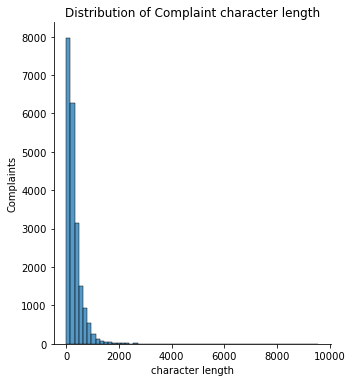

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(char) for char in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("character length")
plt.ylabel("Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

In [25]:
#!pip install wordcloud

#### Find the top 40 words by frequency among all the articles after processing the text.

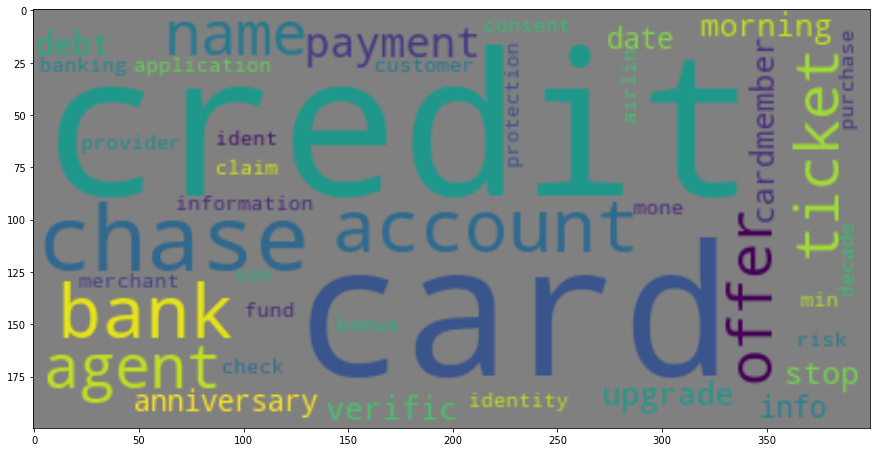

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import STOPWORDS, WordCloud 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_words=40, 
                      background_color="gray", 
                      random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [27]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [28]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,chase card was reported on xx/xx/2019. however...,chase card be report on xx / xx/2019 . however...,card application identity consent credit ident...,card application identity consent credit ident...
11,"on xx/xx/2018, while trying to book a xxxx xx...","on xx / xx/2018 , while try to book a xxxx x...",ticket offer ticket card information offer min...,ticket offer ticket card information offer min...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son check chase account fund bank account mone...,son check chase account fund bank account mone...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
def ngrams_freq(df, n=None, ngram=(1,1)):
    sent = df.values.astype('U')
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram).fit(sent)
    vector = vectorizer.transform(sent)
    sum_vector = vector.sum(axis=0)
    #print(vectorizer.get_feature_names_out())
    #print(sum_vector.toarray())
    words_frequency = [(word, sum_vector[0, index]) for word, index in vectorizer.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
    return words_frequency[:n]

In [30]:
#find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigram = ngrams_freq(df_clean['Complaint_clean'],30,ngram=(1,1))

In [31]:
#Print the top 10 words in the unigram frequency
print(top_30_unigram[:10])

[('account', 41348), ('chase', 32916), ('credit', 32013), ('card', 26675), ('bank', 17137), ('payment', 14075), ('time', 12181), ('money', 11969), ('loan', 9910), ('information', 9675)]


In [32]:
#find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigram = ngrams_freq(df_clean['Complaint_clean'],30,ngram=(2,2))

In [33]:
#Print the top 10 words in the bigram frequency
print(top_30_bigram[:10])

[('credit card', 11046), ('account account', 3465), ('credit report', 3210), ('customer service', 3014), ('chase account', 2577), ('bank account', 2393), ('chase credit', 2375), ('account chase', 2178), ('debit card', 1882), ('card account', 1737)]


In [34]:
#find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigram = ngrams_freq(df_clean['Complaint_clean'],30,ngram=(3,3))

In [35]:
#Print the top 10 words in the trigram frequency
print(top_30_trigram[:10])

[('chase credit card', 1461), ('credit card account', 924), ('credit card company', 826), ('credit card credit', 739), ('credit card chase', 596), ('card credit card', 549), ('credit report credit', 400), ('account credit card', 390), ('account account account', 358), ('account chase account', 337)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,chase card was reported on xx/xx/2019. however...,chase card be report on xx / xx/2019 . however...,card application identity consent credit ident...,card application identity consent credit ident...
11,"on xx/xx/2018, while trying to book a xxxx xx...","on xx / xx/2018 , while try to book a xxxx x...",ticket offer ticket card information offer min...,ticket offer ticket card information offer min...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son check chase account fund bank account mone...,son check chase account fund bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade credit chase bonus airlin...,card customer decade credit chase bonus airlin...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk chase bank chase banking merchant merchan...,risk chase bank chase banking merchant merchan...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit credit chase freedom balance life plent...,credit credit chase freedom balance life plent...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer 
Vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfid = Vectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task I have perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [42]:
nmf_model.fit(tfid)
len(Vectorizer.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



5450

In [43]:
topic_model_matrix = nmf_model.components_

In [44]:
feature_name = Vectorizer.get_feature_names()

In [45]:
feature_name = np.array(feature_name)

In [46]:
topic_model = pd.DataFrame(np.zeros((num_topics,15)), columns = [f'Word{i}' for i in range(1,16)], index = [f'Topic{i}' for i in range(1,num_topics+1)]).astype(str)
topic_model

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Topic2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Topic3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Topic4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Topic5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#Print the Top15 words for each of the topics
for i,topic_words in enumerate(topic_model_matrix):
    ind = topic_words.argsort()[::-1]
    for j in range(15):
        topic_model.iloc[i][j] = feature_name[ind[j]]
topic_model

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15
Topic1,account,bank,money,check,chase,branch,deposit,number,business,fraud,checking,transaction,claim,information,customer
Topic2,card,credit,chase,charge,fraud,dispute,company,fee,merchant,time,purchase,service,debit,number,balance
Topic3,loan,mortgage,home,modification,chase,property,foreclosure,time,letter,house,rate,sale,information,process,company
Topic4,credit,report,inquiry,score,debt,reporting,information,account,bureaus,identity,limit,theft,company,history,application
Topic5,payment,balance,month,fee,statement,auto,date,time,day,error,chase,car,history,account,credit


Topics from observation:
- Topic 1 = Bank account services
- Topic 2 = Credit card / Prepaid card
- Topic 3 = Others
- Topic 4 = Theft/Dispute reporting
- Topic 5 = Mortgages/loans

In [48]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic = nmf_model.transform(tfid)

In [49]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic.argmax(axis=1)

In [50]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,1
10,chase card was reported on xx/xx/2019. however...,chase card be report on xx / xx/2019 . however...,card application identity consent credit ident...,card application identity consent credit ident...,3
11,"on xx/xx/2018, while trying to book a xxxx xx...","on xx / xx/2018 , while try to book a xxxx x...",ticket offer ticket card information offer min...,ticket offer ticket card information offer min...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,0


In [51]:
#Print the first 5 Complaint for each of the Topics
df_clean_top5=df_clean.groupby('Topic').head(5)
df_clean_top5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,account auto,account auto,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account code everything account deposit bonus ...,account code everything account deposit bonus ...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card catering order funeral amoun...,chase amazon card catering order funeral amoun...,1
21,"on xxxx xx/xx/2019, i made a {$300.00} payment...","on xxxx xx / xx/2019 , I make a { $ 300.00 } p...",payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,1
48,"jp morgan chase bank, please answer the follow...","jp morgan chase bank , please answer the follo...",chase information reason information chase acc...,chase information reason information chase acc...,1
40,"xxxx xxxx a sofa, love seat, table and chairs ...","xxxx xxxx a sofa , love seat , table and chair...",sofa love seat table debit card visa claim fur...,sofa love seat table debit card visa claim fur...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank account services", 1:"Credit card or Prepaid card", 2:"Others", 3:"Theft/Dispute reporting", 4:"Mortgage/loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [53]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,Bank account services
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,Credit card or Prepaid card
10,chase card was reported on xx/xx/2019. however...,chase card be report on xx / xx/2019 . however...,card application identity consent credit ident...,card application identity consent credit ident...,Theft/Dispute reporting
11,"on xx/xx/2018, while trying to book a xxxx xx...","on xx / xx/2018 , while try to book a xxxx x...",ticket offer ticket card information offer min...,ticket offer ticket card information offer min...,Theft/Dispute reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade credit chase bonus airlin...,card customer decade credit chase bonus airlin...,Credit card or Prepaid card
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",credit card provider claim purchase protection...,credit card provider claim purchase protection...,Credit card or Prepaid card
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk chase bank chase banking merchant merchan...,risk chase bank chase banking merchant merchan...,Bank account services
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit credit chase freedom balance life plent...,credit credit chase freedom balance life plent...,Mortgage/loan


## Supervised model to predict any new complaints to the relevant Topics.

In [54]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank account services":0, "Credit card or Prepaid card":1, "Others":2, "Theft/Dispute reporting":3, "Mortgage/loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [55]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,I upgrade my xxxx xxxx card in xx / xx/2018 an...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,1
10,chase card was reported on xx/xx/2019. however...,chase card be report on xx / xx/2019 . however...,card application identity consent credit ident...,card application identity consent credit ident...,3
11,"on xx/xx/2018, while trying to book a xxxx xx...","on xx / xx/2018 , while try to book a xxxx x...",ticket offer ticket card information offer min...,ticket offer ticket card information offer min...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son check chase account fund bank account mone...,son check chase account fund bank account mone...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade credit chase bonus airlin...,card customer decade credit chase bonus airlin...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call cha , my ...",credit card provider claim purchase protection...,credit card provider claim purchase protection...,1
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk chase bank chase banking merchant merchan...,risk chase bank chase banking merchant merchan...,0
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit credit chase freedom balance life plent...,credit credit chase freedom balance life plent...,4


In [56]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [57]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/2018 and...,1
10,chase card was reported on xx/xx/2019. however...,3
11,"on xx/xx/2018, while trying to book a xxxx xx...",3
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",1
78310,i am not familiar with xxxx pay and did not un...,0
78311,i have had flawless credit for yrs. i've had ...,4


#### Apply the supervised models on the training data created. In this process I have followed the following process:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [64]:
#Write your code to get the Vector count
cnt_Vectorizer = CountVectorizer()
X_train_cnt = cnt_Vectorizer.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

I have trained on following model:
* Logistic regression
* Decision Tree
* Random Forest


# Logistic regression

In [69]:
# Importing libaries for Logistic Regression.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.metrics import precision_score, recall_score, f1_score
#from sklearn.metrics import plot_roc_curve


In [65]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

In [66]:
logreg = LogisticRegression(random_state=40).fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Model Evaluation**

In [67]:
# Getting the score of the base model
logreg.score(X_test, y_test)

0.9186966149952547

In [68]:
# Make predictions on test data
y_pred = logreg.predict(X_test)

In [70]:
print(confusion_matrix(y_test, y_pred))

[[1755   52   13   10    6]
 [  71 1657    6   19    5]
 [  35   27 1017   15   11]
 [  35   53   25  782   14]
 [  57   30   23    7  597]]


In [71]:
# Print Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1836
           1       0.91      0.94      0.93      1758
           2       0.94      0.92      0.93      1105
           3       0.94      0.86      0.90       909
           4       0.94      0.84      0.89       714

    accuracy                           0.92      6322
   macro avg       0.93      0.90      0.91      6322
weighted avg       0.92      0.92      0.92      6322



**Inference:** Overall accuracy is 92% and precision and recall is 93% and 90% each so it seems to be a good model

# Decision Tree

In [77]:
# Importing library for DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [73]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

In [74]:
#Decision tree
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [75]:
#Score of the model on test data
dt.score(X_test, y_test)

0.8275862068965517

The accuracy of the model is 82% which is less then logistic regression but will see the accuricy after appling hyperparameter tuning 

In [78]:
grid = {"max_depth": [5, 10, 15],
           "min_samples_split": [10, 20, 30],
           "min_samples_leaf": [10, 20, 30]}

In [79]:
# Setup grid hyperparameter search for LogisticRegression
dt_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_cv.fit(X_train, y_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


**Model Evaluation**

In [80]:
dt_cv.best_params_

{'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 10}

In [81]:
dt_cv.score(X_test, y_test)

0.835336918696615

In [82]:
dt_pred = dt_cv.predict(X_test)

In [84]:
# Print Classification Report
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1836
           1       0.86      0.85      0.86      1758
           2       0.75      0.87      0.81      1105
           3       0.83      0.77      0.80       909
           4       0.84      0.77      0.80       714

    accuracy                           0.84      6322
   macro avg       0.83      0.82      0.83      6322
weighted avg       0.84      0.84      0.84      6322



**Inferance:** The score doesnot improve much but 83% is good accuracy. Logestic regression has been the best model till now.

# Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [88]:
rf.score(X_test, y_test)

0.7964251819044607

The accuracy of the model is 79% which is less then logistic regression but will see the accuracy after appling hyperparameter tuning 

In [89]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": [2, 20, 2],
           "min_samples_leaf": [1, 20, 2]}

In [92]:
# Setup random hyperparameter search for LogisticRegression
rf_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Model Evaluation**

In [93]:
rf_cv.score(X_test, y_test)

0.6678266371401456

In [94]:
rf_cv.best_params_

{'n_estimators': 360,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_depth': 10}

In [95]:
rf_pred = rf.predict(X_test)

In [96]:
# Print Classification Report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1836
           1       0.75      0.88      0.81      1758
           2       0.87      0.86      0.86      1105
           3       0.87      0.65      0.75       909
           4       0.93      0.33      0.49       714

    accuracy                           0.80      6322
   macro avg       0.84      0.73      0.75      6322
weighted avg       0.81      0.80      0.78      6322



# Overall Result

Logistic Regression
- The overall accuracy of the Logistic Regression model is 92%.
- Precision and Recall are 93% and 90% respectively which makes this is a very good model.

Decision Tree
- The overal accuracy of Decision Tree is 84%
- Precision and Recall are 83% and 82% respectively which is good but not better then logistic.

Random Forest
- The overall accuracy of Random Forest is 80%
- Precision and Recall are 84% and 73% respectively which is the least of the three model.

# Conclusion

Besed on the above result Logistic Regression has the best result.